In [1]:
import torch  
import torch.nn as nn  
from torchvision.models import resnet101  
from torchvision.models.resnet import ResNet101_Weights 
import os
import csv  
import shutil  
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50,deeplabv3_resnet101
from PIL import Image
from tqdm import tqdm
from tqdm.auto import tqdm
from torch import optim
from torchvision.transforms import functional as F
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torchvision.models.segmentation as segmentation
from torchvision.transforms.functional import to_pil_image

class ECALayer(nn.Module):
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(ECALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)
    
    
    
class ModifiedResNet101(nn.Module):
    def __init__(self, pretrained=True):
        super(ModifiedResNet101, self).__init__()

        # ResNet-101
        backbone = resnet101(weights=ResNet101_Weights.DEFAULT)

        # Trở lại conv 3 kênh ban đầu
        self.firstconv = backbone.conv1  # Sử dụng trực tiếp conv1 gốc
        
        # Nhân đôi các lớp còn lại
        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.maxpool = backbone.maxpool

        # Thêm lớp với mô-đun ECA
        self.layer1 = self._make_layer(backbone.layer1, ECALayer, 256)
        self.layer2 = self._make_layer(backbone.layer2, ECALayer, 512)
        self.layer3 = self._make_layer(backbone.layer3, ECALayer, 1024)
        self.layer4 = self._make_layer(backbone.layer4, ECALayer, 2048)

        # Xóa lớp được kết nối đầy đủ
        del backbone.fc
        self.fc = None

    def _make_layer(self, layer, ECALayer, planes):
        layers = []
        for module in layer.children():
            if isinstance(module, nn.Sequential):
                # Thay thế khối dư ban đầu bằng khối dư mới bằng mô-đun ECA
                new_block = self._add_eca_to_block(module, ECALayer, planes)
                layers.append(new_block)
            else:
                layers.append(module)
        return nn.Sequential(*layers)

    def _add_eca_to_block(self, block, ECALayer, planes):
        # Tạo khối dư mới chứa mô-đun ECA
        eca_block = nn.Sequential(
            block,
            ECALayer(planes)
        )
        return eca_block

    def forward(self, x):
        x = self.firstconv(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates):
        super(ASPP, self).__init__()
        out_channels = 256  #  xác định một số kênh đầu ra cố định
        self.blocks = []
        for rate in atrous_rates:
            self.blocks.append(nn.Conv2d(in_channels, out_channels, 3, padding=rate, dilation=rate))
        self.blocks = nn.ModuleList(self.blocks)
        self.project = nn.Sequential(
            nn.Conv2d(len(atrous_rates) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),  
        )

    def forward(self, x):
        out = []
        for block in self.blocks:
            out.append(block(x))
        out = torch.cat(out, dim=1)
        return self.project(out)

class Decoder(nn.Module):
    def __init__(self, low_level_in_channels, num_classes):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(low_level_in_channels + 256, 256, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.last_conv = nn.Conv2d(256, num_classes, 1)
        self.eca = ECALayer(256)

    def forward(self, x, low_level_features):
        # Nâng cấp mẫu x lên cùng kích thước với low_level_features
        x = F.interpolate(x, size=low_level_features.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, low_level_features], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.eca(x)
        x = self.last_conv(x)
        return x
    
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepLabV3Plus, self).__init__()

        # Sử dụng ModifiedResNet101 làm mạng đường trục
        self.backbone = ModifiedResNet101(pretrained=True)
        
        in_channels = 2048  # ResNet-101

        atrous_rates = [6, 12, 18]
        self.aspp = ASPP(in_channels, atrous_rates)

        # Chọn lớp tương ứng với bản đồ đặc trưng cấp thấp
        low_level_channels = 256  # ResNet-101 layer1 
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        self.decoder = Decoder(48, num_classes)
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)

    def forward(self, x):
        # Mạng đường trục qua ResNet-101
        x = self.backbone.firstconv(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
    
        # Nhận bản đồ tính năng cấp thấp
        low_level_features = self.backbone.layer1(x)
        
        # Thay đổi cách xử lý low_level_features
        x = self.backbone.layer2(low_level_features)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
    
        x = self.aspp(x)  # Đầu vào phải là đầu ra của lớp cuối cùng
        low_level_features = self.low_level_conv(low_level_features)
        x = self.decoder(x, low_level_features)
        x = self.upsample(x)
        
        return x
    
#Tạo phiên bản mô hình
model = DeepLabV3Plus(num_classes=2)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:12<00:00, 13.8MB/s] 


Triển khai Dataset và Data Augmentation

In [2]:
def load_image(file_path):
    return np.array(Image.open(file_path))


class LandslideDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, phase='train', transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks') 
        self.images = [f for f in os.listdir(self.image_dir) if f.endswith('.png')]
    
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        img = load_image(img_path)
        original_img = img.copy()
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('image', 'mask'))
        mask = load_image(mask_path)
      
        
        sample = {'image': img,  'mask': mask, 'original_img': original_img}
        
        if self.transforms:
            sample = self.transforms(sample)
            
        return sample

def transform(sample):
    image, mask, original_img = sample['image'], sample['mask'], sample['original_img']
    
    # Data augmentation
    if random.random() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
        
    if random.random() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
        
    if random.random() > 0.5:
        angle = random.choice([90, 180, 270])
        image = np.rot90(image, k=angle//90)
        mask = np.rot90(mask, k=angle//90)
        

    
    # Convert to PIL Image and apply transforms
    original_img= T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor()
    ])(original_img)
    image = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])(image)
    mask = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224), interpolation=Image.NEAREST),
        T.ToTensor()
    ])(mask)
    
    # Concatenate image and dem, and return the transformed sample
    return {'image': image, 'mask': mask, 'original_img': original_img}


Tạo DataLoader cho tập huấn luyện, xác thực và kiểm tra

In [3]:
train_root_dir = "/kaggle/input/datals2/train"  
val_root_dir = "/kaggle/input/datals2/validation"  
test_root_dir = "/kaggle/input/datals2/test" 
# Tạo một phiên bản tập dữ liệu
train_dataset =  LandslideDataset(root_dir=train_root_dir, transforms=transform)  
val_dataset =  LandslideDataset(root_dir=val_root_dir, transforms=transform)  
test_dataset =  LandslideDataset(root_dir=test_root_dir, transforms=transform)  
  
# DataLoader  
#Đối với tập huấn luyện, thường đặt shuffle=True để xáo trộn dữ liệu một cách ngẫu nhiên
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)  
  
# Đối với các tập hợp xác thực và kiểm tra, thường không cần xáo trộn dữ liệu
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)  
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0) 

Huấn luyện và đánh giá mô hình DeepLabV3+

In [4]:
# criterion = torch.nn.BCELoss()  
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).float()  
    acc = correct.sum() / correct.numel()  
    return acc
def train_one_epoch(epoch, model, dataloader, device):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    progress_bar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch} Training")
    for batch in progress_bar:
        inputs = batch['image'].to(device,dtype=torch.float32)
        masks = batch['mask'][:, 0, :, :].to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
       
       
        loss = criterion(outputs, masks)
        acc = calculate_accuracy(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_accuracy += acc.item()
        progress_bar.set_postfix({'Training Loss': f"{loss.item():.4f}", 'Accuracy': f"{acc.item():.4f}"})
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / len(dataloader)
    print(f"Epoch {epoch} Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    return epoch_loss, epoch_accuracy
def validate(epoch, model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    progress_bar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch} Validation")
    with torch.no_grad():
        for batch in progress_bar:
            inputs = batch['image'].to(device,dtype=torch.float32)
            masks = batch['mask'][:, 0, :, :].to(device, dtype=torch.long)
            
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            acc = calculate_accuracy(outputs, masks)
            running_loss += loss.item()
            running_accuracy += acc.item()
            progress_bar.set_postfix({'Validation Loss': f"{loss.item():.4f}", 'Accuracy': f"{acc.item():.4f}"})
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / len(dataloader)
    print(f"Epoch {epoch} Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    return epoch_loss, epoch_accuracy


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


num_epochs = 50

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(epoch, model, train_loader, device)
    val_loss, val_acc = validate(epoch, model, val_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch 1 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1 Training Loss: 0.4475, Accuracy: 0.8976


Epoch 1 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 0.3279, Accuracy: 0.9578


Epoch 2 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2 Training Loss: 0.2546, Accuracy: 0.9596


Epoch 2 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 0.2134, Accuracy: 0.9665


Epoch 3 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3 Training Loss: 0.1857, Accuracy: 0.9635


Epoch 3 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 0.1607, Accuracy: 0.9680


Epoch 4 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4 Training Loss: 0.1482, Accuracy: 0.9661


Epoch 4 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 0.1315, Accuracy: 0.9708


Epoch 5 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 5 Training Loss: 0.1257, Accuracy: 0.9676


Epoch 5 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 0.1138, Accuracy: 0.9716


Epoch 6 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 6 Training Loss: 0.1110, Accuracy: 0.9687


Epoch 6 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 0.1005, Accuracy: 0.9716


Epoch 7 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 7 Training Loss: 0.0999, Accuracy: 0.9700


Epoch 7 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 0.0939, Accuracy: 0.9735


Epoch 8 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 8 Training Loss: 0.0914, Accuracy: 0.9714


Epoch 8 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 0.0845, Accuracy: 0.9736


Epoch 9 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 9 Training Loss: 0.0858, Accuracy: 0.9719


Epoch 9 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 0.0754, Accuracy: 0.9750


Epoch 10 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 10 Training Loss: 0.0813, Accuracy: 0.9727


Epoch 10 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 0.0787, Accuracy: 0.9747


Epoch 11 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 11 Training Loss: 0.0777, Accuracy: 0.9731


Epoch 11 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 Validation Loss: 0.0688, Accuracy: 0.9759


Epoch 12 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 12 Training Loss: 0.0743, Accuracy: 0.9737


Epoch 12 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 Validation Loss: 0.0695, Accuracy: 0.9758


Epoch 13 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 13 Training Loss: 0.0720, Accuracy: 0.9742


Epoch 13 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 Validation Loss: 0.0670, Accuracy: 0.9757


Epoch 14 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 14 Training Loss: 0.0690, Accuracy: 0.9749


Epoch 14 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 Validation Loss: 0.0662, Accuracy: 0.9757


Epoch 15 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 15 Training Loss: 0.0674, Accuracy: 0.9751


Epoch 15 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 Validation Loss: 0.0631, Accuracy: 0.9767


Epoch 16 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 16 Training Loss: 0.0654, Accuracy: 0.9757


Epoch 16 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 Validation Loss: 0.0620, Accuracy: 0.9768


Epoch 17 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 17 Training Loss: 0.0644, Accuracy: 0.9757


Epoch 17 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 Validation Loss: 0.0623, Accuracy: 0.9767


Epoch 18 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 18 Training Loss: 0.0639, Accuracy: 0.9757


Epoch 18 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 Validation Loss: 0.0615, Accuracy: 0.9765


Epoch 19 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 19 Training Loss: 0.0621, Accuracy: 0.9762


Epoch 19 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 Validation Loss: 0.0595, Accuracy: 0.9768


Epoch 20 Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 20 Training Loss: 0.0611, Accuracy: 0.9764


Epoch 20 Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 Validation Loss: 0.0590, Accuracy: 0.9770


Lưu kết quả huấn luyện và đánh giá vào file CSV

In [5]:
# Xác định đường dẫn thư mục
folder_path = '/kaggle/working/csv_directory'  
  
# Kiểm tra xem thư mục có tồn tại không
if os.path.exists(folder_path):  
      
    # Ngoài ra, nếu bạn chỉ muốn làm trống thư mục thay vì xóa nó, bạn có thể sử dụng đoạn mã sau 
    for filename in os.listdir(folder_path):  
        file_path = os.path.join(folder_path, filename)  
        try:  
            if os.path.isfile(file_path) or os.path.islink(file_path):  
                os.unlink(file_path)  
            elif os.path.isdir(file_path):  
                shutil.rmtree(file_path)  
        except Exception as e:  
            print(f'xóa bỏ {file_path} lỗi: {e}')  
      
    # Ở đây chúng ta chỉ in thông báo thay vì xóa thư mục 
    print(f"thư mục {folder_path} Đã tồn tại。")  
else:  
    # Thư mục không tồn tại, hãy tạo nó
    os.makedirs(folder_path, exist_ok=True)  
    print(f"thư mục {folder_path} Tạo。")


# Xác định đường dẫn tập tin  
filename = '/kaggle/working/csv_directory/training_validation_results.csv'  
  
# CSV
with open(filename, mode='w', newline='') as file:  
    writer = csv.writer(file)  
      
    # Viết tiêu đề
    writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'])  
      
    #epoch，Ghi dữ liệu 
    for epoch in range(1, len(train_losses) + 1):  
        writer.writerow([epoch, train_losses[epoch-1], train_accuracies[epoch-1], val_losses[epoch-1], val_accuracies[epoch-1]])  
  
print(f'Results saved to {filename}')

thư mục /kaggle/working/csv_directory Tạo。
Results saved to /kaggle/working/csv_directory/training_validation_results.csv


Vẽ và lưu biểu đồ Loss và Accuracy trong quá trình huấn luyện và đánh giá

thư mục /kaggle/working/loss_accuracy_directory tạo。


<Figure size 1200x500 with 0 Axes>

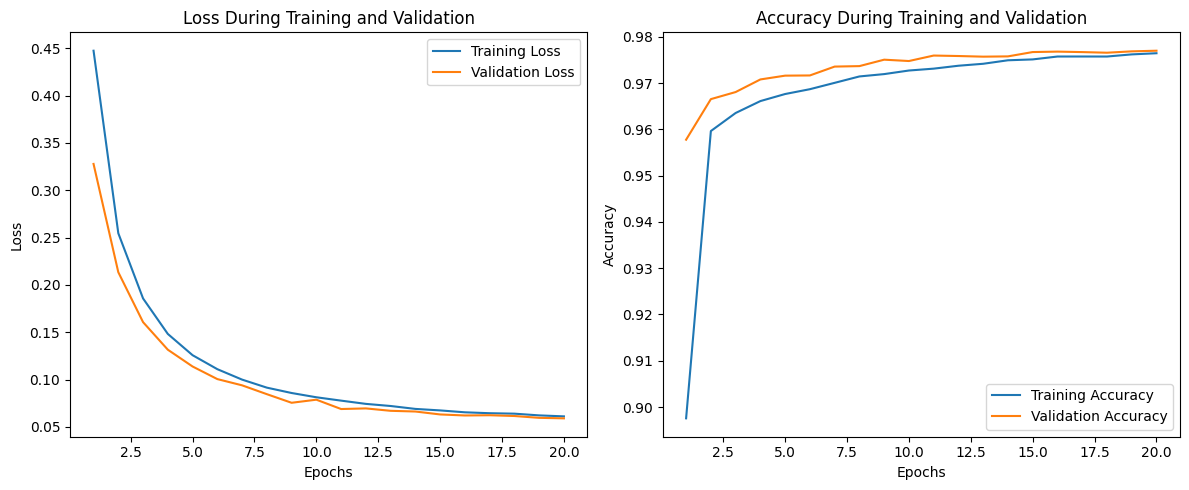

In [6]:

folder_path = '/kaggle/working/loss_accuracy_directory'  
 
if os.path.exists(folder_path):       
    for filename in os.listdir(folder_path):  
        file_path = os.path.join(folder_path, filename)  
        try:  
            if os.path.isfile(file_path) or os.path.islink(file_path):  
                os.unlink(file_path)  
            elif os.path.isdir(file_path):  
                shutil.rmtree(file_path)  
        except Exception as e:  
            print(f'xóa bỏ{file_path} lỗi: {e}')  
  
    print(f"thư mục {folder_path} Đã tồn tại。")  
else:  
     
    os.makedirs(folder_path, exist_ok=True)  
    print(f"thư mục {folder_path} tạo。")


plt.figure(figsize=(12, 5))


plt.figure(figsize=(6, 5))  
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training and Validation')
plt.legend()
plt.tight_layout()  
plt.savefig("/kaggle/working/loss_accuracy_directory/training_validation_loss.png")
plt.close()  


plt.figure(figsize=(6, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training and Validation')
plt.legend()
plt.tight_layout()  
plt.savefig("/kaggle/working/loss_accuracy_directory/training_validation_accuracy.png")  # 保存第二个子图
plt.close()  


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training and Validation')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training and Validation')
plt.legend()


plt.tight_layout()


plt.savefig("/kaggle/working/loss_accuracy_directory/loss_and_accuracy.png")


plt.show()

Trực quan hóa và lưu kết quả dự đoán của mô hình trên tập kiểm tra

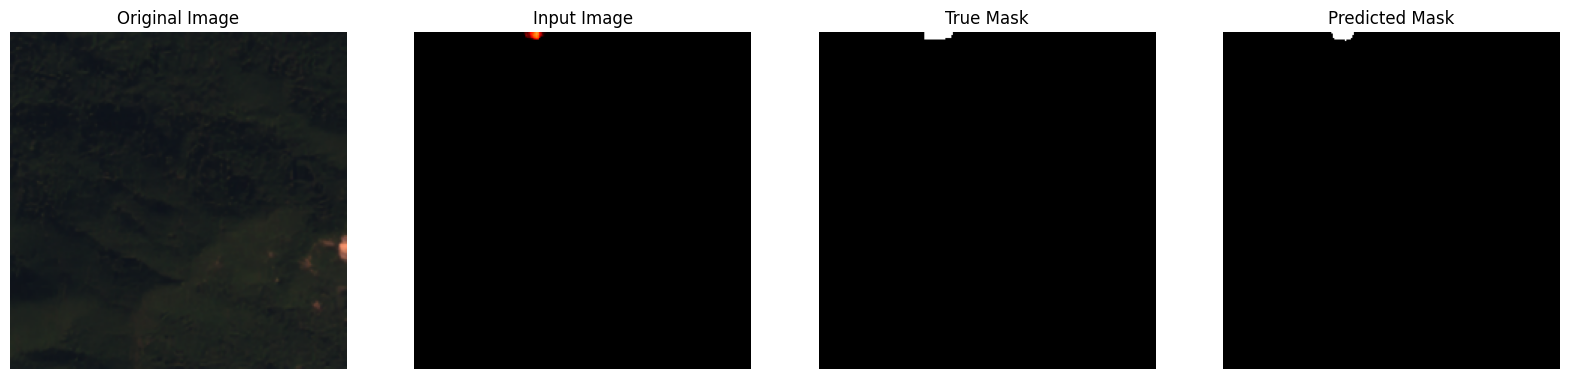

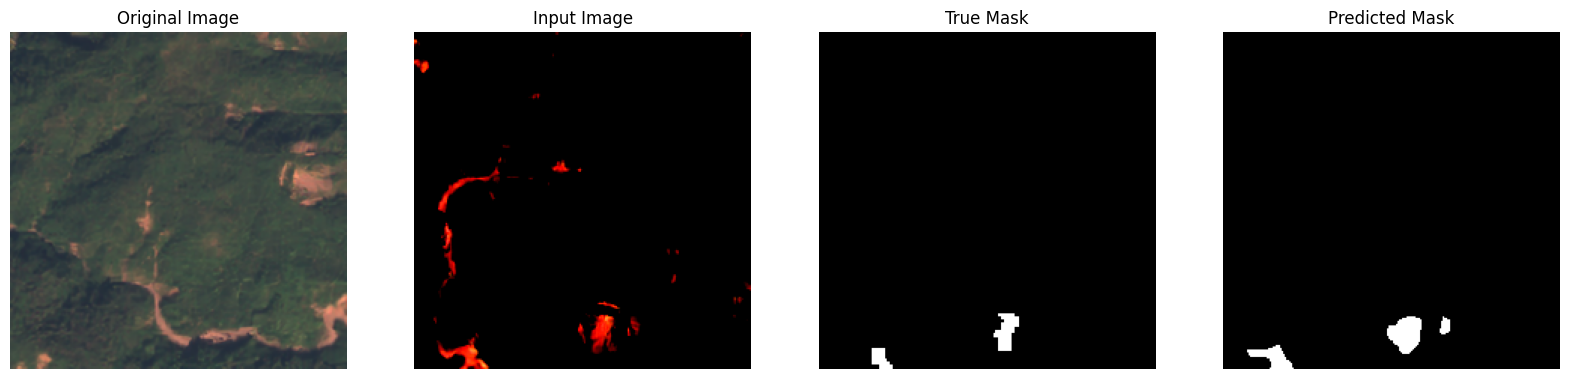

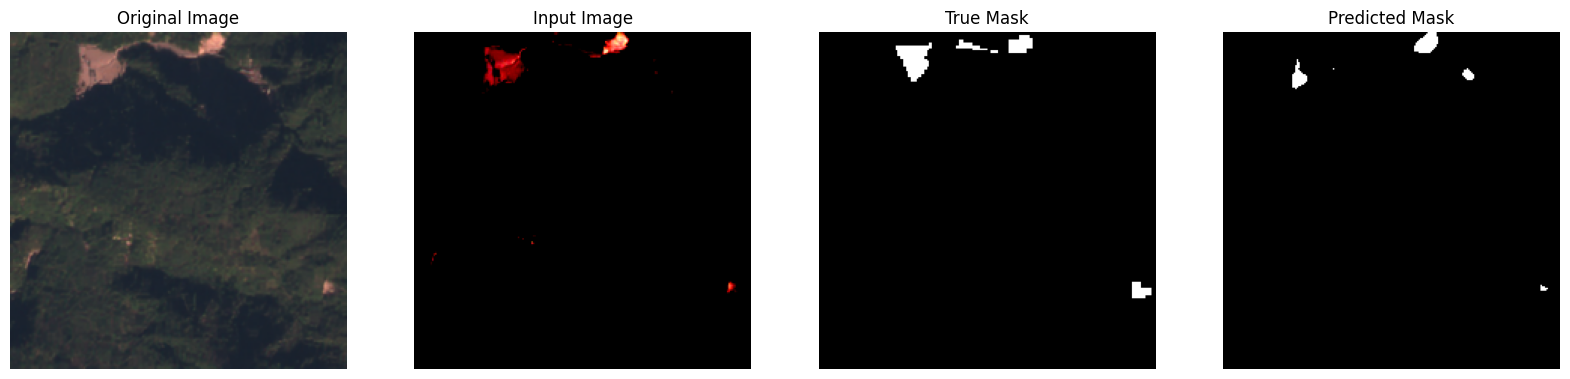

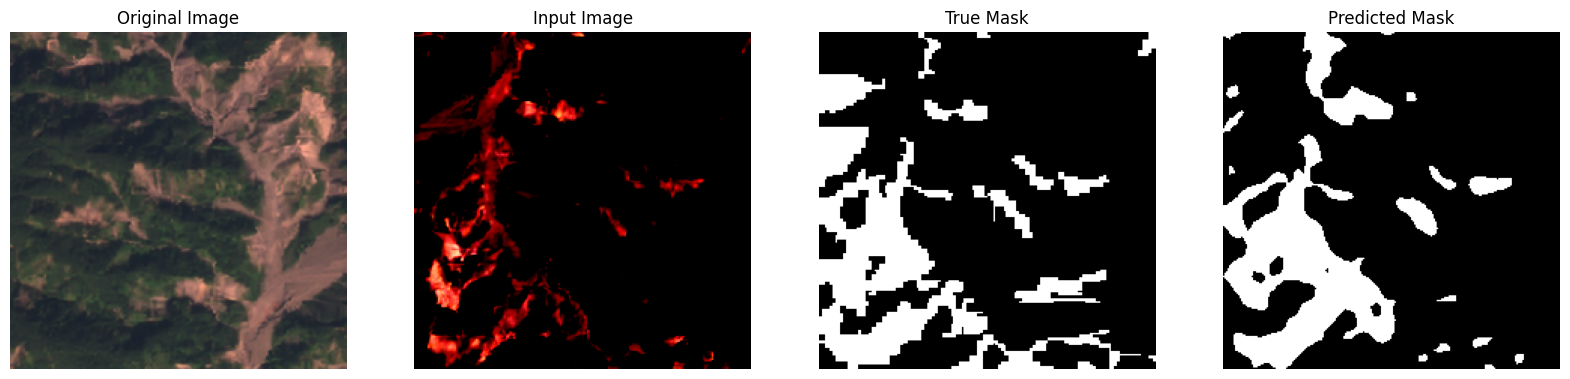

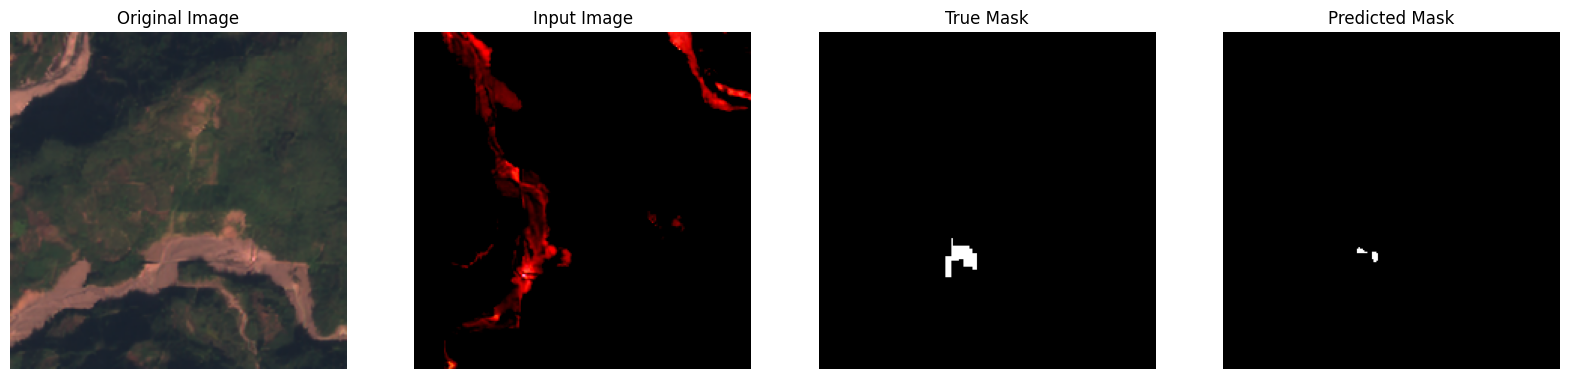

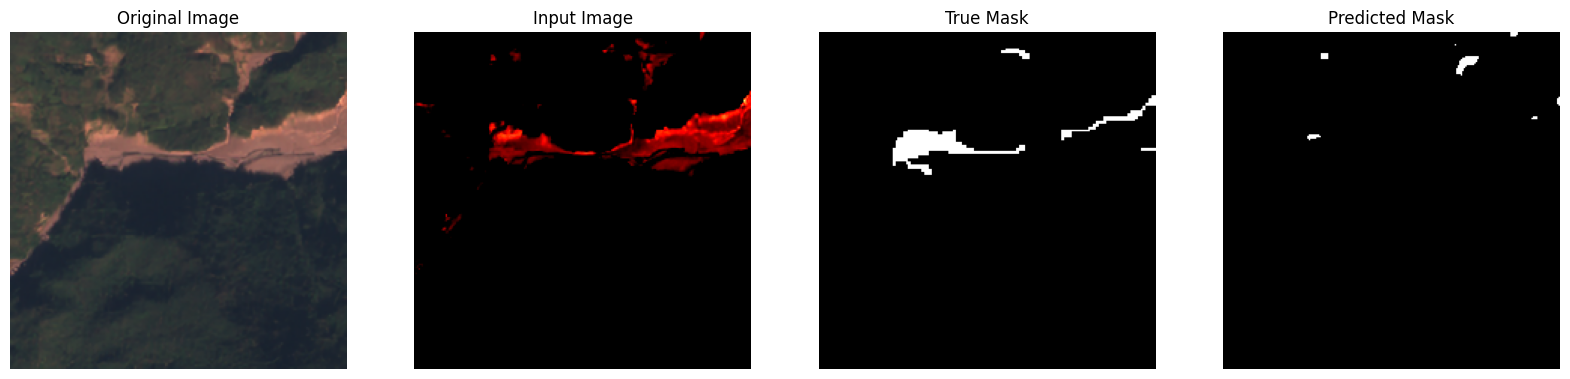

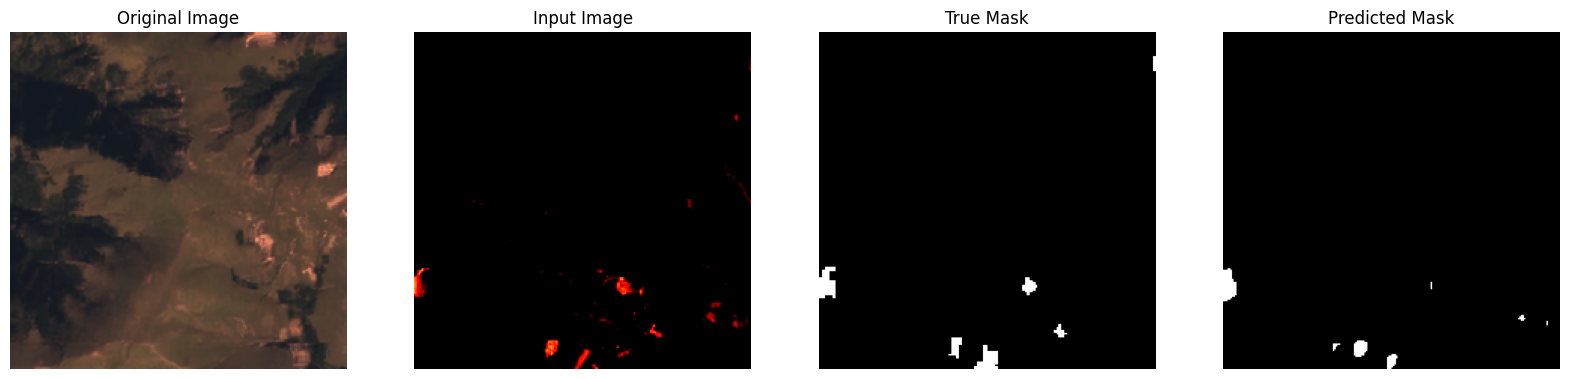

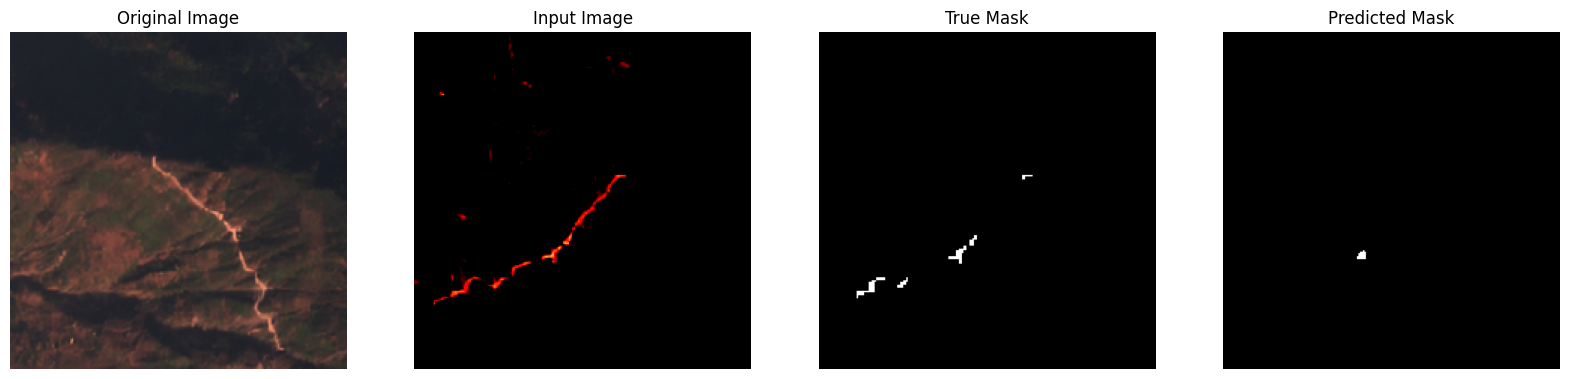

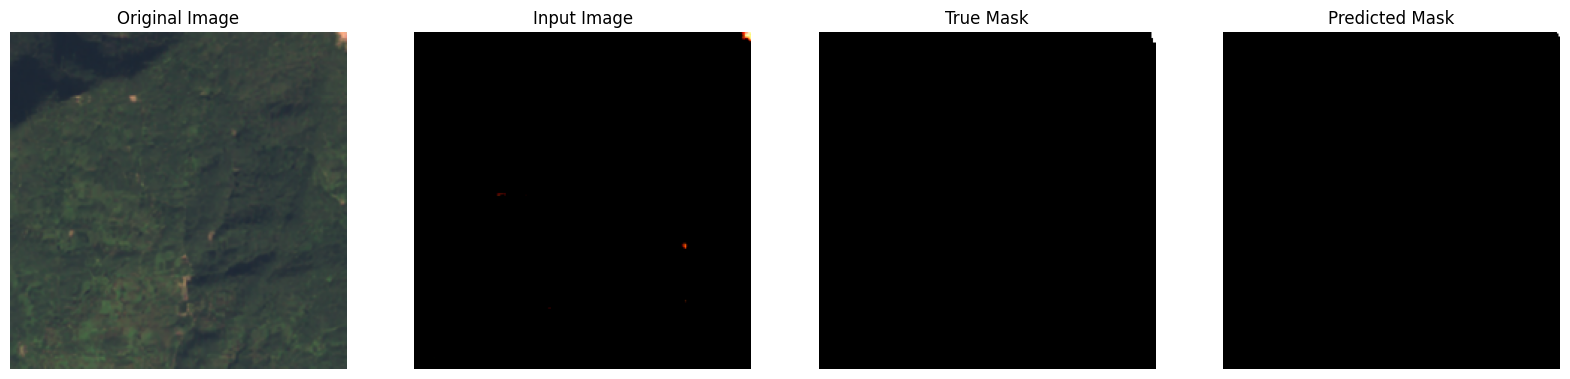

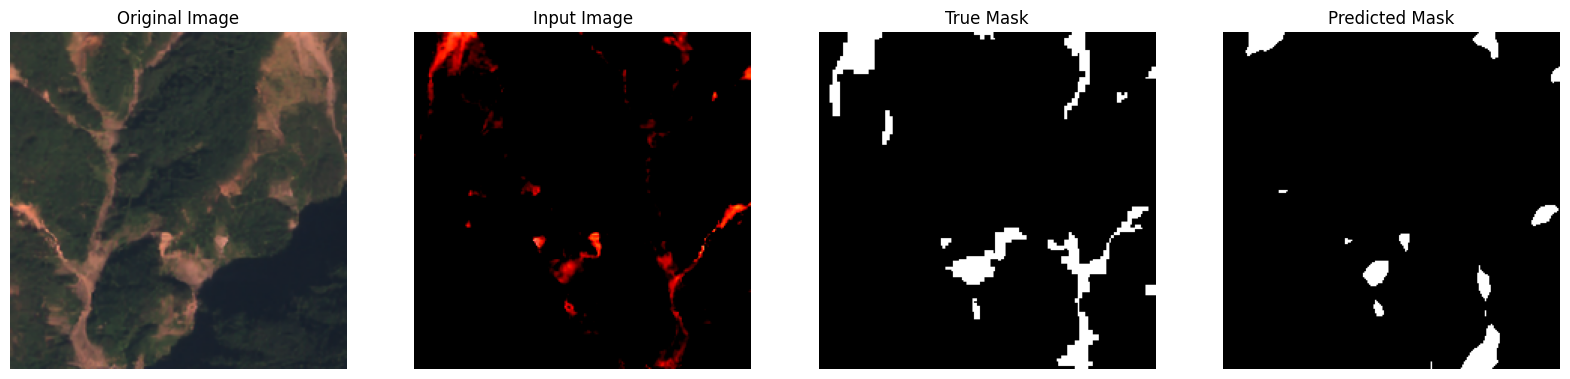

In [7]:
def denormalize(tensor, mean, std):
    """
    Khôi phục tensor chuẩn hóa về phạm vi ban đầu của nó.
    :param tensor: (Tensor) Tensor cần khôi phục
    :param có nghĩa: (danh sách) giá trị trung bình của các kênh hình ảnh
    :param std: (danh sách) độ lệch chuẩn của kênh hình ảnh
    :return: (Tensor) Tensor được khôi phục
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


def ensure_dir_empty(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        os.makedirs(directory)  

def visualize_predictions(dataset, model, device, num_examples=20, save_path='/kaggle/working/predict_directory'):
    model.eval()
    

    ensure_dir_empty(save_path)
    
   
    subfolders = ['Original Image', 'Input Image', 'True Mask', 'Predicted Mask']
    for folder in subfolders:
        
        subfolder_path = os.path.join(save_path, folder)
       
        os.makedirs(subfolder_path, exist_ok=True)
    
    samples = torch.utils.data.Subset(dataset, range(num_examples))
    loader = DataLoader(samples, batch_size=1, shuffle=False)
    
    with torch.no_grad():
        for i, batch in enumerate(loader):
            inputs = batch['image'].to(device)
            originals = batch['original_img'].to(device)
            true_masks = batch['mask'][:, 0, :, :].squeeze(1).numpy()

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            inputs = inputs.cpu().clamp(0, 1)
            originals = originals.cpu().clamp(0, 1)

           
            fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
            
            
            axs[0].imshow(originals.numpy()[0][0:3].transpose(1, 2, 0))
            axs[0].set_title('Original Image')
            axs[0].axis('off')

            axs[1].imshow(inputs.numpy()[0][0:3].transpose(1, 2, 0))
            axs[1].set_title('Input Image')
            axs[1].axis('off')

            axs[2].imshow(true_masks[0], cmap='gray')
            axs[2].set_title('True Mask')
            axs[2].axis('off')

            axs[3].imshow(preds[0], cmap='gray')
            axs[3].set_title('Predicted Mask')
            axs[3].axis('off')

            
            plt.show()

        
            for j, subplot in enumerate(['Original Image', 'Input Image', 'True Mask', 'Predicted Mask']):
                plt.figure(figsize=(5, 5)) 
                
                if subplot == 'Original Image':
                    plt.imshow(originals.numpy()[0][0:3].transpose(1, 2, 0))
                elif subplot == 'Input Image':
                    plt.imshow(inputs.numpy()[0][0:3].transpose(1, 2, 0))
                elif subplot == 'True Mask':
                    plt.imshow(true_masks[0], cmap='gray')
                elif subplot == 'Predicted Mask':
                    plt.imshow(preds[0], cmap='gray')
                
                plt.axis('off')
                
               
                plt.savefig(os.path.join(save_path, subplot, f'{subplot}_{i+1}.png'), bbox_inches='tight', pad_inches=0)
                plt.close() 
 
visualize_predictions(test_dataset, model, device, num_examples=10)

Epoch 1 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Test Results: Precision: 0.8703, Recall: 0.7802, F1 Score: 0.8183, mIoU: 0.3932


Epoch 2 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Test Results: Precision: 0.8750, Recall: 0.7868, F1 Score: 0.8244, mIoU: 0.4027


Epoch 3 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Test Results: Precision: 0.8658, Recall: 0.7870, F1 Score: 0.8211, mIoU: 0.3992


Epoch 4 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Test Results: Precision: 0.8713, Recall: 0.7883, F1 Score: 0.8240, mIoU: 0.4005


Epoch 5 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Test Results: Precision: 0.8740, Recall: 0.7888, F1 Score: 0.8253, mIoU: 0.4021


Epoch 6 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 Test Results: Precision: 0.8713, Recall: 0.7834, F1 Score: 0.8207, mIoU: 0.4011


Epoch 7 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 Test Results: Precision: 0.8763, Recall: 0.7816, F1 Score: 0.8214, mIoU: 0.3930


Epoch 8 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 Test Results: Precision: 0.8714, Recall: 0.7886, F1 Score: 0.8242, mIoU: 0.3976


Epoch 9 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 Test Results: Precision: 0.8720, Recall: 0.7794, F1 Score: 0.8184, mIoU: 0.3876


Epoch 10 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 Test Results: Precision: 0.8756, Recall: 0.7862, F1 Score: 0.8242, mIoU: 0.3990


Epoch 11 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11 Test Results: Precision: 0.8665, Recall: 0.7881, F1 Score: 0.8221, mIoU: 0.3995


Epoch 12 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12 Test Results: Precision: 0.8717, Recall: 0.7857, F1 Score: 0.8224, mIoU: 0.4013


Epoch 13 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13 Test Results: Precision: 0.8743, Recall: 0.7881, F1 Score: 0.8249, mIoU: 0.4002


Epoch 14 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14 Test Results: Precision: 0.8679, Recall: 0.7924, F1 Score: 0.8253, mIoU: 0.4061


Epoch 15 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15 Test Results: Precision: 0.8694, Recall: 0.7867, F1 Score: 0.8222, mIoU: 0.4056


Epoch 16 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16 Test Results: Precision: 0.8740, Recall: 0.7874, F1 Score: 0.8244, mIoU: 0.4019


Epoch 17 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17 Test Results: Precision: 0.8691, Recall: 0.7841, F1 Score: 0.8204, mIoU: 0.3999


Epoch 18 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18 Test Results: Precision: 0.8734, Recall: 0.7902, F1 Score: 0.8260, mIoU: 0.4008


Epoch 19 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19 Test Results: Precision: 0.8719, Recall: 0.7907, F1 Score: 0.8257, mIoU: 0.4042


Epoch 20 Test:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20 Test Results: Precision: 0.8675, Recall: 0.7863, F1 Score: 0.8213, mIoU: 0.3961
Total 20 Average Precision: 0.8714, Average Recall: 0.7865, Average F1 Score: 0.8228, Average mIoU: 0.3996


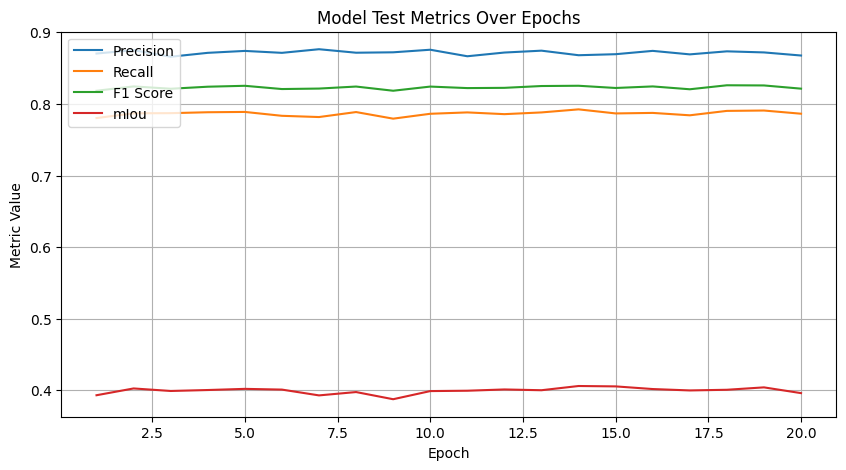

Normalized confusion matrix


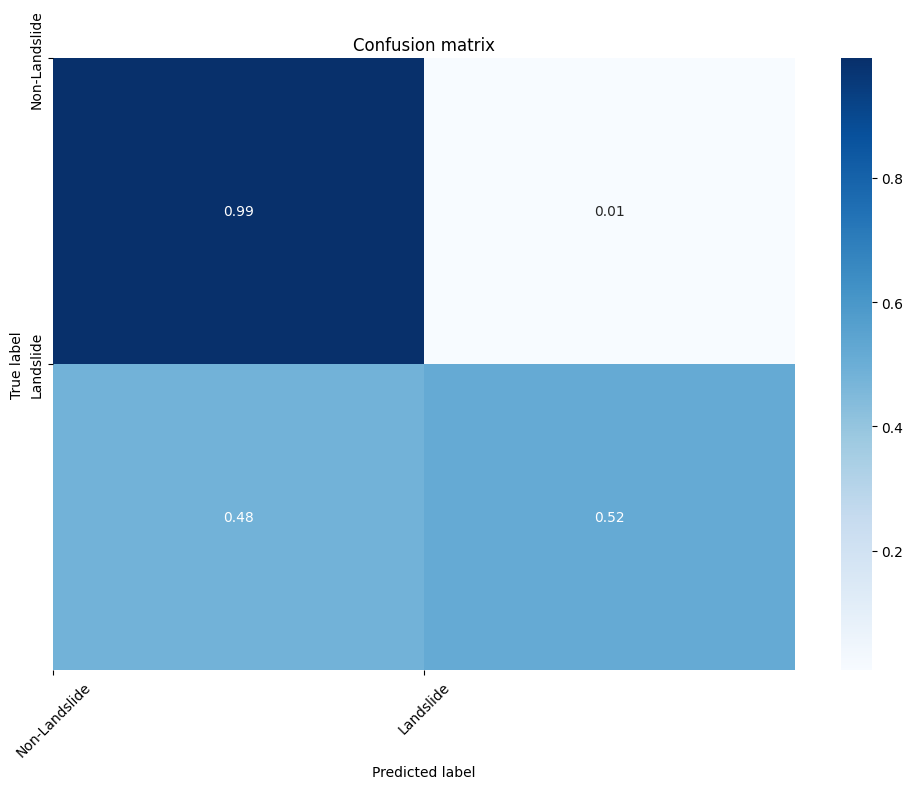

In [8]:
dir_path = '/kaggle/working/confusion matrix_directory'
os.makedirs(dir_path, exist_ok=True)
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn.metrics import confusion_matrix

def evaluate_metrics(model, dataloader, device,epoch):  
    model.eval()  
    all_preds, all_true = [], [] 
    all_predicts,all_targets = [],[]
    progress_bar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch} Test")  
    with torch.no_grad():  
        for batch in progress_bar:  
            inputs = batch['image'].to(device)  
            true_masks = batch['mask'][:, 0, :, :].to(device, dtype=torch.long).squeeze(1)  
            outputs = model(inputs)  
            preds = torch.argmax(outputs, dim=1) 
            all_preds.append(preds)  
            all_true.append(true_masks)  
  
  

        all_preds = torch.cat(all_preds, dim=0).cpu().numpy()  
        all_true = torch.cat(all_true, dim=0).cpu().numpy()  
  
      
        intersection = (all_preds & all_true).astype(np.float32)  
        union = (all_preds | all_true).astype(np.float32)  
        iou_per_image = (np.sum(intersection, axis=(1, 2)) + 1e-7) / (np.sum(union, axis=(1, 2)) + 1e-7)  
        mIou = np.mean(iou_per_image)  
  
       
        precision = precision_score(all_true.flatten(), all_preds.flatten(), average='macro')  
        recall = recall_score(all_true.flatten(), all_preds.flatten(), average='macro')  
        f1 = f1_score(all_true.flatten(), all_preds.flatten(), average='macro')  
        
        
        
        
        all_predicts.extend(preds.view(-1).cpu().numpy())  
            
        all_targets.extend(true_masks.view(-1).cpu().numpy())
        cm = confusion_matrix(all_targets, all_predicts)
        
        
  
          
        print(f"Epoch {epoch} Test Results: Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, mIoU: {mIou:.4f}")
    return precision, recall, f1, mIou ,cm
  
metrics_history = {'precision': [], 'recall': [], 'f1': [], 'mIou': []}

def plot_metrics(metrics_history,save_dir='/kaggle/working/saved_plots', filename='metrics_over_epochs.png'):
    ensure_dir_empty(save_dir)
    epochs = range(1, len(metrics_history['f1']) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics_history['precision'], label='Precision')
    plt.plot(epochs, metrics_history['recall'], label='Recall')
    plt.plot(epochs, metrics_history['f1'], label='F1 Score')
    plt.plot(epochs, metrics_history['mIou'], label='mIou')
    plt.title('Model Test Metrics Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend(loc='upper left') 
    plt.grid(True)
    save_path = "/kaggle/working/saved_plots/metrics_over_epochs.png"  
    plt.savefig(save_path)  
    plt.show()
    


def plot_confusion_matrix(val_cm, classes=None, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        val_cm = val_cm.astype('float') / val_cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 8))
    sns.heatmap(val_cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/confusion matrix_directory/confusion matrix.png')
    plt.show()
    

for epoch in range(1, num_epochs + 1):
    precision, recall, f1, mIou,test_cm= evaluate_metrics(model, test_loader, device,epoch)
    metrics_history['precision'].append(precision)
    metrics_history['recall'].append(recall)
    metrics_history['f1'].append(f1)
    metrics_history['mIou'].append(mIou)  
  
  
 
avg_precision = np.mean(metrics_history['precision'])  
avg_recall = np.mean(metrics_history['recall'])  
avg_f1 = np.mean(metrics_history['f1'])  
avg_miou = np.mean(metrics_history['mIou'])  
   
print(f"Total {num_epochs} Average Precision: {avg_precision:.4f}, Average Recall: {avg_recall:.4f}, Average F1 Score: {avg_f1:.4f}, Average mIoU: {avg_miou:.4f}")  
  

plot_metrics(metrics_history,save_dir='/kaggle/working/saved_plots')
plot_confusion_matrix(test_cm, classes=['Non-Landslide', 'Landslide'], normalize=True)